### Set tuning parameters and call the data

In [1]:
alpha = 1/6 # the proportion of the validation set
num_epoch = 5 # how many epochs should we repeat.
learning_rate = 0.001
batch_size=128

In [2]:
import torch 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np

In [3]:
train_dataset = MNIST(root='data/', download=False, train=True, transform = transforms.ToTensor())
torch.manual_seed(0)

### Split the training data and grasp the size of the data

In [4]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
train_ds, val_ds = random_split(train_dataset, [len(train_dataset) - int(len(train_dataset) * alpha), int(len(train_dataset) * alpha)])
train_loader = DataLoader(train_ds, batch_size, shuffle=True)

In [5]:
dimension = train_ds[0][0].shape
input_size = np.prod(dimension)
_, labels=zip(*train_dataset)
num_classes = len(np.unique(labels))

### Construct the model and set up the number of epochs.

In [6]:
import torch.nn as nn
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb=xb.reshape(-1, input_size)
        out=self.linear(xb)
        return out

In [7]:
import torch.nn.functional as F
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
history = []

### Iteration box

In [8]:
for epoch in range(num_epoch):
    
    ### optimizing once for each batch
    for xb,yb in train_loader:
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ### assess performance with validation dataset
    images,labels=zip(*val_ds)
    images=torch.cat(images).reshape(len(val_ds),dimension[0],dimension[1],dimension[2])
    labels=torch.tensor(labels)
    preds = model(images)
    loss_val = F.cross_entropy(preds, labels) # validation
    _, predoutcomes = torch.max(preds, dim=1)
    acc_val = torch.sum(predoutcomes==labels).item() / len(labels) # validation

    ### record the performance in the history
    history.append((loss_val, acc_val))
    print('Epoch [{}/{}], Loss: {:.4f}, accuracy: {:.4f}'.format(epoch+1, num_epoch, loss_val, acc_val))

Epoch [1/5], Loss: 1.9569, accuracy: 0.6429
Epoch [2/5], Loss: 1.6873, accuracy: 0.7227
Epoch [3/5], Loss: 1.4865, accuracy: 0.7486
Epoch [4/5], Loss: 1.3350, accuracy: 0.7717
Epoch [5/5], Loss: 1.2185, accuracy: 0.7860


### Plot

Text(0.5, 1.0, 'Accuracy vs No.of epochs')

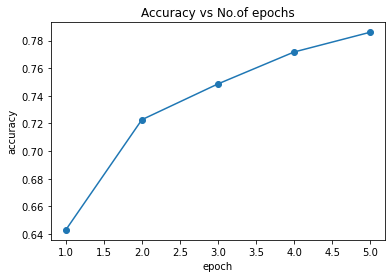

In [9]:
_,accuracies=zip(*history)
import matplotlib.pyplot as plt
plt.plot(np.arange(len(history))+1, accuracies, '-o') # in order to start the epoch from 1.
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No.of epochs')

### Apply to the test data

In [10]:
test_ds = MNIST(root='data/', download=False, train=False, transform = transforms.ToTensor())

In [11]:
images_test,labels_test=zip(*test_ds)
images_test=torch.cat(images_test).reshape(len(test_ds),dimension[0],dimension[1],dimension[2])
labels_test=torch.tensor(labels_test)
preds = model(images_test)
loss_val = F.cross_entropy(preds, labels_test) # validation
_, predoutcomes = torch.max(preds, dim=1)
acc_val = torch.sum(predoutcomes==labels_test).item() / len(labels) # validation

In [12]:
loss_val.item(), acc_val

(1.198830246925354, 0.8)

### Save and call the model and apply

In [13]:
torch.save(model.state_dict(), 'data/mnist-logistic.pth')

In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [15]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np

In [17]:
test_ds = MNIST(root='data/', download=False, train=False, transform = transforms.ToTensor())
images_test, labels_test = zip(*test_ds)
num_classes = len(np.unique(labels_test))
input_size = np.prod(images_test[0].shape)
dimension = images_test[0].shape

In [18]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb=xb.reshape(-1, input_size)
        out=self.linear(xb)
        return out

In [19]:
model = MnistModel()
model.load_state_dict(torch.load('data/mnist-logistic.pth'))

<All keys matched successfully>

In [21]:
images_test,labels_test=zip(*test_ds)
images_test=torch.cat(images_test).reshape(len(test_ds),dimension[0],dimension[1],dimension[2])
labels_test=torch.tensor(labels_test)
preds = model(images_test)
loss_val = F.cross_entropy(preds, labels_test) # validation
_, predoutcomes = torch.max(preds, dim=1)
acc_val = torch.sum(predoutcomes==labels_test).item() / len(labels_test) # validation

In [22]:
loss_val.item(), acc_val

(1.198830246925354, 0.8)

* Before treating the validation set as a single chunk, it was originally as follows, which includes the procedure of splitting the validation dataset.

val_loader = DataLoader(val_ds, batch_size, shuffle=False)

for epoch in range(1):
    
    ### optimizing one step
    for xb,yb in train_loader:
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ### assess performance based on validation dataset
    accu_vec = [] # Never do accu_vec=num_vec=[] in python! Updating one automatically updates the other.
    num_vec = []
    loss_vec = []
    for xb,yb in val_loader:
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        _, predoutcomes = torch.max(preds, dim=1)
        accu_batch = torch.sum(predoutcomes==yb) / len(yb)
        accu_vec.append(accu_batch.item())
        loss_vec.append(loss.item())
        num_vec.append(len(yb))

    ### record the performance in the history
    avg_accuracy = np.sum(np.multiply(accu_vec, num_vec) / np.sum(num_vec))
    avg_loss = np.sum(np.multiply(loss_vec, num_vec) / np.sum(num_vec))
    history.append((avg_accuracy, avg_loss))
    print('Epoch [{}/{}], Loss: {:.4f}, accuracy: {:.4f}'.format(epoch+1, num_epoch, avg_loss, avg_accuracy))


